In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
import sys
sys.path.append('..')
from dataset import batcher

In [123]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [279]:
# Load model
experiments = ['imagery_sample_cnn_regression_5epoch']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [280]:
# Get test split
test_batcher = batcher.Batcher(bucket=False, shuffle=False, split='test', repeat=1, batch_size=652).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 3)


In [281]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-01-29 15:41:27.454457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[-7.02770710e-01]
 [-4.83517140e-01]
 [-8.20962310e-01]
 [-1.38092026e-01]
 [-6.61777735e-01]
 [-7.29231804e-04]
 [-7.29231804e-04]
 [-3.04269314e-01]
 [-1.36056751e-01]
 [ 2.09023952e-01]
 [ 5.44214435e-02]
 [-7.29231804e-04]
 [ 2.95960546e-01]
 [-3.44286472e-01]
 [ 2.51517206e-01]
 [-2.95463532e-01]
 [-7.29231804e-04]
 [ 5.74914932e-01]
 [ 3.61312293e-02]
 [-7.29231804e-04]
 [ 1.24618672e-02]
 [ 1.83937829e-02]
 [-1.50532238e-02]
 [ 2.41530202e-02]
 [-3.04269314e-01]
 [ 1.42248139e-01]
 [-6.02692142e-02]
 [ 9.24583748e-02]
 [ 1.05053671e-01]
 [-5.65783441e-01]
 [-4.45597768e-01]
 [ 3.98674309e-02]
 [-2.95681763e-03]
 [ 3.87014970e-02]
 [-1.92854083e+00]
 [-7.05271363e-01]
 [-7.29231804e-04]
 [-5.12667060e-01]
 [-2.87347045e-02]
 [-3.04269314e-01]
 [-7.29231804e-04]
 [-5.93137026e-01]
 [-4.68393624e-01]
 [ 2.00116098e-01]
 [-1.42692864e+00]
 [ 8.61772597e-02]
 [ 2.09023952e-01]
 [ 3.71159285e-01]
 [ 9.10795480e-02]
 [-9.22210455e-01]
 [ 7.02084005e-02]
 [-6.78128228e-02]
 [-7.5315916

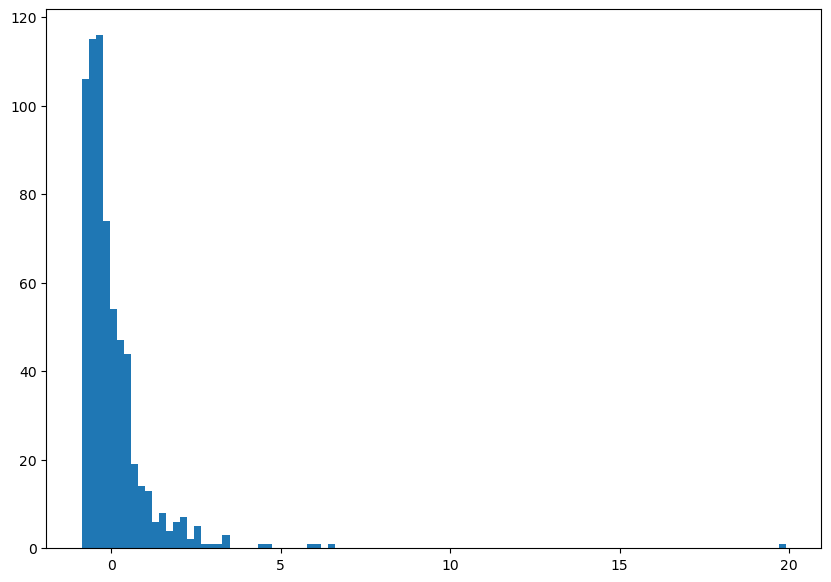

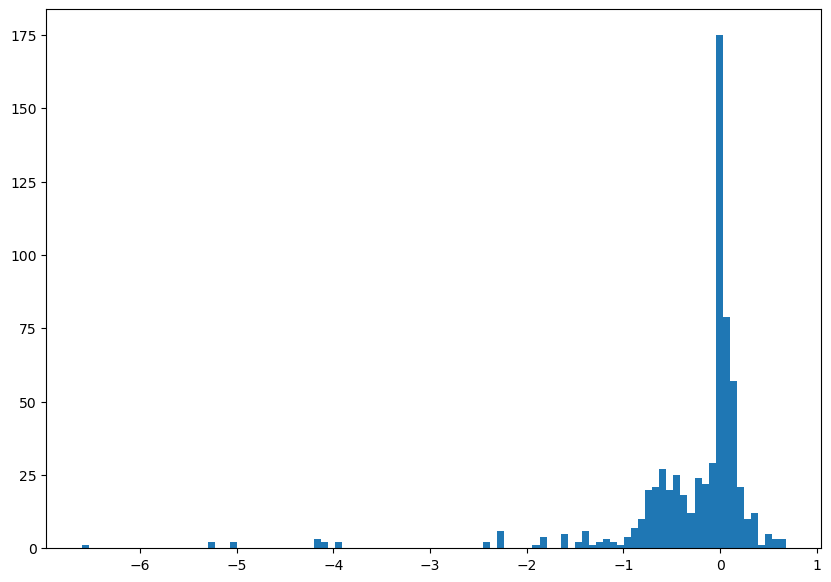

In [282]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()


r2 = pearsonr(y_true, y_preds)[0]

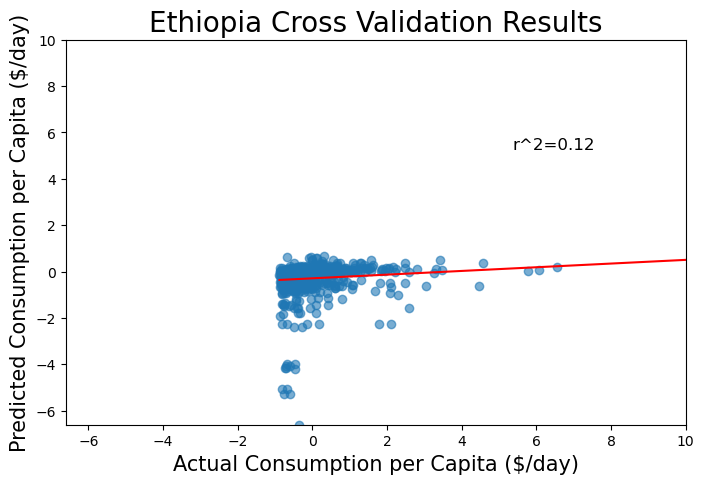

In [291]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
plt.xlim([np.min(y_preds), 10])
plt.ylim([np.min(y_preds), 10])
plt.show()